1) Использует target encoder

2) Заоплняет пропуски средним и создает колонку с флагом того, что тут был пропуск

3) Использует синус и косинус для циклических переменных

4) комбитнации признаков(буквально создаются ._col1_col2_...) кодируются через таргет кодирование



In [41]:
import os
import shap
import math
import random
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np, pandas as pd
from colorama import Fore, Style
from itertools import combinations
from numpy.typing import ArrayLike
from sklearn.base import BaseEstimator
from sklearn.model_selection import KFold
from sklearn.preprocessing import TargetEncoder  # Новый встроенный энкодер
from sklearn.preprocessing import QuantileTransformer

import tensorflow as tf
#import deeptables as dt
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers.legacy import Adam
#from deeptables.utils.shap import DeepTablesExplainer
#from deeptables.models import DeepTable, ModelConfig, deepnets

warnings.filterwarnings('ignore')

In [42]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
seed_everything(seed=42)

In [43]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (750000, 12)
Test shape: (250000, 11)


In [44]:
podcast_type_mapping = {
    # Новости и аналитика
    'News Roundup': 1,
    'Global News': 1,
    'World Watch': 1,
    'Current Affairs': 1,
    
    # Технологии и гаджеты
    'Tech Talks': 2,
    'Tech Trends': 2,
    'Gadget Geek': 2,
    'Digital Digest': 2,
    'Innovators': 2,
    
    # Спорт
    'Sports Central': 3,
    'Sports Weekly': 3,
    'Sport Spot': 3,
    'Game Day': 3,
    "Athlete's Arena": 3,
    
    # Юмор
    'Comedy Corner': 4,
    'Funny Folks': 4,
    'Humor Hub': 4,
    'Laugh Line': 4,
    'Joke Junction': 4,
    
    # Здоровье и образ жизни
    'Fitness First': 5,
    'Mind & Body': 5,
    'Wellness Wave': 5,
    'Healthy Living': 5,
    'Health Hour': 5,
    'Home & Living': 5,
    'Lifestyle Lounge': 5,
    
    # Бизнес и финансы
    'Business Briefs': 6,
    'Money Matters': 6,
    'Finance Focus': 6,
    'Market Masters': 6,
    'Business Insights': 6,
    
    # Музыка
    'Music Matters': 7,
    'Melody Mix': 7,
    'Sound Waves': 7,
    'Tune Time': 7,
    
    # Образование и наука
    'Study Sessions': 8,
    'Learning Lab': 8,
    'Educational Nuggets': 8,
    'Brain Boost': 8,
    'Life Lessons': 8,
    
    # Криминал и детективы
    'Criminal Minds': 9,
    'Crime Chronicles': 9,
    'Detective Diaries': 9,
    'True Crime Stories': 9,
    
    # Мода
    'Fashion Forward': 10,
    'Style Guide': 10,
    
    # Разное (если не входит в другие категории)
    'Mystery Matters': 11,
    'Daily Digest': 12,
}

podcast_author_mapping = {
    # Авторские группы по ключевым словам
    'Music Matters': 1,   #Matters Media
    'Money Matters': 1,
    'Mystery Matters': 1,
    
    'Daily Digest': 2,    #Digest Network
    'Digital Digest': 2,
    
    'Sports Central': 3,  #Sports Network
    'Sports Weekly': 3,

    'Tech Talks': 4,  #Tech Media
    'Tech Trends': 4,
    
    'Business Briefs': 5,     #Business Media
    'Business Insights': 5,
    
    'Study Sessions': -1,
    'Learning Lab': -1,
    'Educational Nuggets': -1,
    'Brain Boost': -1,
    'Fashion Forward': -1,
    'Style Guide': -1,
    'Game Day': -1,
    'Athlete\'s Arena': -1,
    'Innovators': -1,
    'Home & Living': -1,
    'Lifestyle Lounge': -1,
    'Life Lessons': -1,
    'Sport Spot': -1,
    'Comedy Corner': -1,
    'Humor Hub': -1,
    'Funny Folks': -1,
    'Laugh Line': -1,
    'Joke Junction': -1,
    'Gadget Geek': -1,
    'News Roundup': -1,
    'Global News': -1,
    'World Watch': -1,
    'Current Affairs': -1,
    'Fitness First': -1,
    'Mind & Body': -1,
    'Wellness Wave': -1,
    'Healthy Living': -1,
    'Health Hour': -1,
    'Market Masters': -1,
    'Finance Focus': -1,
    'Melody Mix': -1,
    'Sound Waves': -1,
    'Tune Time': -1,
    'Criminal Minds': -1,
    'True Crime Stories': -1,
    'Crime Chronicles': -1,
    'Detective Diaries': -1,
}



In [45]:
def df_fix(df, is_tr=False):
    
    df['Episode_Num'] = df['Episode_Title'].str.split(' ').str[1].astype(int)

    dct_Publication_Time = {'Morning': 0, 'Afternoon': 1, 'Evening': 2, 'Night': 3}
    df['Publication_Time_my_enc'] = df['Publication_Time'].map(dct_Publication_Time)

    df['Genre_enc'] = df['Genre'].factorize()[0]
    df['Publication_Day_enc'] = df['Publication_Day'].factorize()[0]

    dct_Episode_Sentiment = {'Positive': 1, 'Negative': -1, 'Neutral': 0}
    df['Episode_Sentiment_enc'] = df['Episode_Sentiment'].map(dct_Episode_Sentiment)

    df['Number_of_Ads'] = df['Number_of_Ads'].mask(df['Number_of_Ads'] >= 12, np.nan)
    df['Host_Popularity_percentage'] = df['Host_Popularity_percentage'].mask(df['Host_Popularity_percentage'] > 100, np.nan)
    df['Host_Popularity_percentage'] = df['Host_Popularity_percentage'].mask(df['Host_Popularity_percentage'] > 100, np.nan)

    if is_tr:
        df['diff'] = df['Listening_Time_minutes'] - df['Episode_Length_minutes']
        df['Listening_Time_minutes'] = df['Listening_Time_minutes'].mask((df['diff'] >= 0) & (df['diff'] < 1), df['Episode_Length_minutes'])
        df = df[df['Listening_Time_minutes'] <= df['Episode_Length_minutes']]


    df['Podcast_Type'] = df['Podcast_Name'].map(podcast_type_mapping)
    df['Podcast_Author'] = df['Podcast_Name'].map(podcast_author_mapping)
    
    return df

train = df_fix(train, True)
test = df_fix(test, False)

In [46]:
def target_encoding(train, target, test=None, feat_to_encode=None, min_samples_leaf=20, smoothing=10.0):
    train = train.copy()
    if test is not None:
        test = test.copy()
    
    train.sort_index(inplace=True)

    if feat_to_encode is None:
        feat_to_encode = train.columns.tolist()
        
    oof_parts = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for tr_idx, oof_idx in kf.split(train, target):
        encoder = TargetEncoder(smooth="auto")  # новый sklearn TargetEncoder
        encoder.fit(train.iloc[tr_idx][feat_to_encode], target.iloc[tr_idx])
        encoded = encoder.transform(train.iloc[oof_idx][feat_to_encode])
        encoded_df = pd.DataFrame(encoded, columns=feat_to_encode, index=train.iloc[oof_idx].index)
        oof_parts.append(encoded_df)

    if test is not None:
        final_encoder = TargetEncoder(smooth="auto")
        final_encoder.fit(train[feat_to_encode], target)
        test[feat_to_encode] = final_encoder.transform(test[feat_to_encode])
    
    train_encoded = pd.concat(oof_parts).sort_index()
    train[feat_to_encode] = train_encoded[feat_to_encode]
    return train, test

In [47]:
%%time
X = train.drop(['id', 'Listening_Time_minutes'], axis=1)
y = train.Listening_Time_minutes
X_test = test.drop(['id'], axis=1)
print("X      shape:", X.shape)
print("X_test shape:", X_test.shape, '\n')

cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(exclude=['object']).columns.tolist()
print("init len(cat_cols):", len(cat_cols))
print("init len(num_cols):", len(num_cols), '\n')

# Only 1 missing value to fill
m_ = X['Number_of_Ads'].mode()[0] 
X['Number_of_Ads'] = X['Number_of_Ads'].fillna(m_)
# Fill missing values and create an indicator column
for c in num_cols:
    if X[c].isna().any():
        m = X[c].mean()
        X[f'NA_{c}'] = X[c].isna().astype('int8')
        X[c] = X[c].fillna(m)
        X_test[f'NA_{c}'] = X_test[c].isna().astype('int8')
        X_test[c] = X_test[c].fillna(m)
        num_cols.append(f'NA_{c}')

pair_size = [2, 3, 4]
time_dict = {'Morning': 0, 'Afternoon': 1, 'Evening': 2, 'Night': 3}
encode_cols = ['Episode_Length_minutes', 'Host_Popularity_percentage',
               'Number_of_Ads', 'Episode_Title', 'Episode_Sentiment',
               'Publication_Time', 'Publication_Day']
        
def feat_eng(df):
    df['_Has_Ads'] = (df['Number_of_Ads'] > 0).astype('int8')
    df['_Is_Weekend'] = df['Publication_Day'].isin(['Saturday', 'Sunday']).astype('int8')
    df['_sin_Episode_Length_minutes'] = np.sin(2*np.pi * df['Episode_Length_minutes'] / 60)
    df['_cos_Episode_Length_minutes'] = np.cos(2*np.pi * df['Episode_Length_minutes'] / 60)
    df['_sin_Host_Popularity_percentage'] = np.sin(2*np.pi * df['Host_Popularity_percentage'] / 20)
    df['_cos_Host_Popularity_percentage'] = np.cos(2*np.pi * df['Host_Popularity_percentage'] / 20)

    df['Publication_Time_enc'] = df['Publication_Time'].replace(time_dict)
    df['_sin_Publication_Time'] = np.sin(2*np.pi * df['Publication_Time_enc'] / 2)
    df['_cos_Publication_Time'] = np.cos(2*np.pi * df['Publication_Time_enc'] / 2)
    for r in pair_size:
        for cols in list(combinations(encode_cols, r)):
            new_col_name = '_'.join(cols)
            df['._'+new_col_name] = df[list(cols)].astype(str).agg('_'.join, axis=1)
            
    df = df.drop(['Publication_Time_enc'], axis=1)
    new_cat_cols = [col for col in df.columns if col.endswith('_')]
    new_num_cols = [col for col in df.columns if col.startswith('_')]
    new_enc_cols = [col for col in df.columns if col.startswith('.')]
    return df, new_cat_cols, new_num_cols, new_enc_cols 

X, new_cat_cols, new_num_cols, new_enc_cols = feat_eng(X)
X_test, new_cat_cols, new_num_cols, new_enc_cols = feat_eng(X_test)
num_cols += new_num_cols; cat_cols += new_cat_cols
print("comb len(enc_cols):", len(new_enc_cols), '\n')


X      shape: (662516, 18)
X_test shape: (250000, 17) 

init len(cat_cols): 6
init len(num_cols): 12 

comb len(enc_cols): 91 

CPU times: total: 3min 54s
Wall time: 3min 55s


In [58]:
X, X_test = target_encoding(X, y, X_test, feat_to_encode=new_enc_cols)
num_cols += new_enc_cols

num_cols = list(set(num_cols) - set(['diff', 'Podcast_Name', 'Episode_Title', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']))

scaler = QuantileTransformer(subsample=10**9)
X[num_cols] = scaler.fit_transform(X[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])
print("prep len(cat_cols):", len(cat_cols))
print("prep len(num_cols):", len(num_cols), '\n')

prep len(cat_cols): 6
prep len(num_cols): 112 




Fold 1
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 9.59823	valid_1's rmse: 9.69939
[1000]	training's rmse: 9.4496	valid_1's rmse: 9.65581
[1500]	training's rmse: 9.32962	valid_1's rmse: 9.63664
[2000]	training's rmse: 9.22281	valid_1's rmse: 9.62483
[2500]	training's rmse: 9.1263	valid_1's rmse: 9.61699
[3000]	training's rmse: 9.03441	valid_1's rmse: 9.61185
Early stopping, best iteration is:
[2938]	training's rmse: 9.04516	valid_1's rmse: 9.6114
Fold 1 RMSE: 9.6114

Fold 2
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 9.6	valid_1's rmse: 9.68191
[1000]	training's rmse: 9.45072	valid_1's rmse: 9.63963
[1500]	training's rmse: 9.3319	valid_1's rmse: 9.62091
[2000]	training's rmse: 9.22531	valid_1's rmse: 9.60731
[2500]	training's rmse: 9.12906	valid_1's rmse: 9.59942
[3000]	training's rmse: 9.03766	valid_1's rmse: 9.59343
Early stopping, best iteration is:
[3134]	training's rmse: 9.01429	valid_1's rmse: 9.59

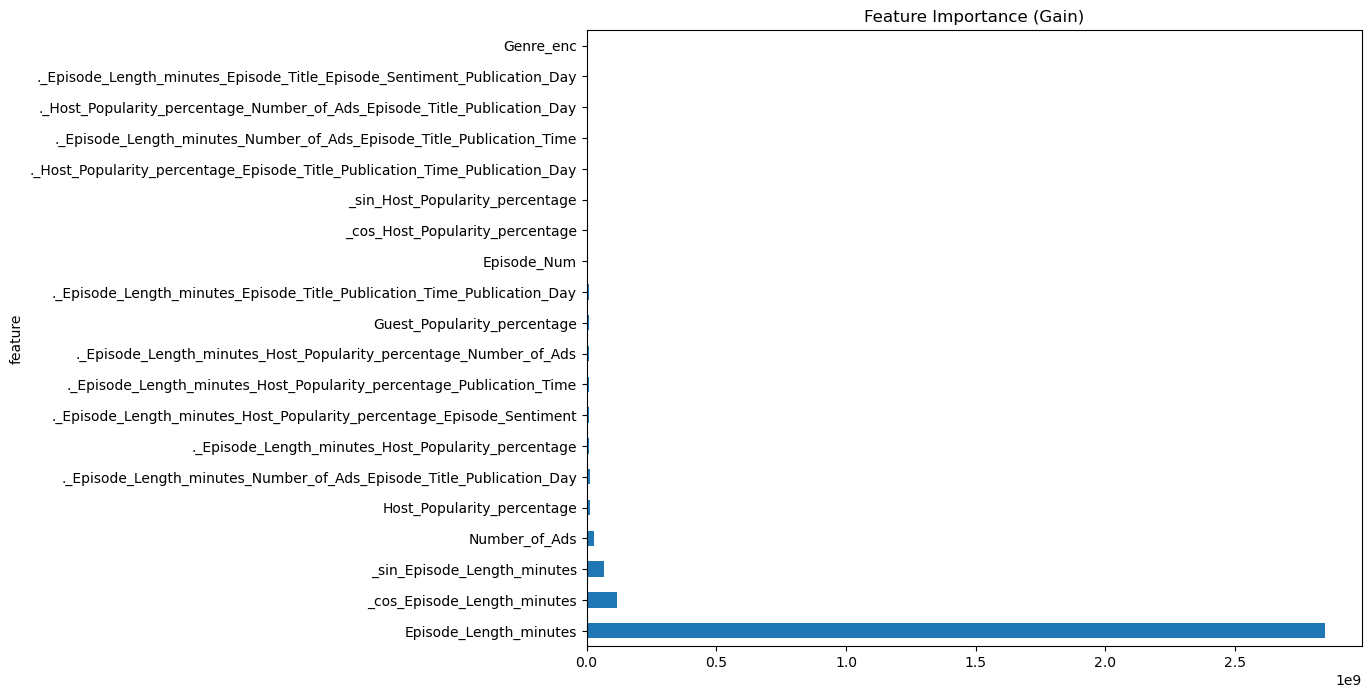

CPU times: total: 1h 16min 16s
Wall time: 6min 37s


In [63]:
%%time
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

cols = list(set(X) - set(['diff', 'Podcast_Name', 'Episode_Title', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']))

# Prepare data
X_train = X[cols].copy()
X_test = X_test[cols]
y_train = y.copy()


# LightGBM parameters (fixed typos and added more common parameters)
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',  # Fixed typo
    'learning_rate': 0.05,
    'num_leaves': 31,
    'min_child_samples': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,  # Fixed typo
    'bagging_freq': 1,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'verbose': -1,
    'random_state': 42
}

# KFold validation
n_folds = 9
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
oof_preds = np.zeros(X_train.shape[0])
test_preds = np.zeros(X_test.shape[0])
feature_importance = pd.DataFrame()

for fold, (train_idx, valid_idx) in enumerate(kf.split(X_train, y_train)):
    print(f"\nFold {fold + 1}")
    
    # Split data
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]
    
    # Create LightGBM datasets
    train_set = lgb.Dataset(X_tr, y_tr)
    valid_set = lgb.Dataset(X_val, y_val, reference=train_set)
    
    # Train model with callbacks instead of early_stopping_rounds parameter
    model = lgb.train(
        params=lgb_params,
        train_set=train_set,
        num_boost_round=10000,
        valid_sets=[train_set, valid_set],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),  # Early stopping callback
            lgb.log_evaluation(500)  # Replaces verbose_eval
        ]
    )
    
    # Predictions
    oof_preds[valid_idx] = model.predict(X_val, num_iteration=model.best_iteration)
    test_preds += model.predict(X_test, num_iteration=model.best_iteration) / n_folds
    
    # Feature importance
    fold_importance = pd.DataFrame({
        "feature": X_train.columns,
        "importance": model.feature_importance(importance_type='gain'),
        "fold": fold + 1
    })
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
    # Fold evaluation
    fold_rmse = np.sqrt(mean_squared_error(y_val, oof_preds[valid_idx]))
    print(f"Fold {fold + 1} RMSE: {fold_rmse:.4f}")

# Overall evaluation
total_rmse = np.sqrt(mean_squared_error(y_train, oof_preds))
print(f"\nOverall OOF RMSE: {total_rmse:.4f}")

# Feature importance visualization
(feature_importance.groupby('feature')['importance']
                   .mean()
                   .sort_values(ascending=False)
                   .head(20)
                   .plot(kind='barh', figsize=(10, 8), title='Feature Importance (Gain)'))
plt.show()

In [60]:

# Подготовка submission файла
submission = pd.DataFrame({
    'id': test['id'],
    'Listening_Time_minutes': test_preds
})
submission

,id,Listening_Time_minutes
0,750000,0.0
1,750001,0.0
2,750002,0.0
3,750003,0.0
4,750004,0.0
...,...,...
249995,999995,0.0
249996,999996,0.0
249997,999997,0.0
249998,999998,0.0


In [ ]:
submission.to_csv('lgb_submission_2.csv', index=False)
print("\nSubmission file saved!")


Submission file saved!
